<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset

In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 

In [3]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


In [4]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

SNR : 18


In [0]:
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [0]:
X_snr = []
y_snr = []

for i in range(X.shape[0]):
    if labels[i,1] == snr:
        X_snr.append(X[i])
        y_snr.append(y[i])

X_snr = np.array(X_snr)
y_snr = np.array(y_snr)  

In [0]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)


In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# StandardScaler expected <= 2.
#X_train = X_train.reshape([6400,256])
X_train = X_train.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test = X_test.reshape([X_test.shape[0],256])
X_test = sc.transform(X_test)
X_test = X_test.reshape([X_test.shape[0],2,128])

# Reshape
X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test = X_test.reshape(-1,2, 128, 1)

# Making CNN0 model 
(Article : Convolutional Radio Modulation Recognition Networks - Timothy J. O’Shea1)

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(64,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(16,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")

Using TensorFlow backend.
W0806 19:47:51.059855 140687306045312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), input_shape=(2, 128, 1..., activation="relu")`
  if sys.path[0] == '':
W0806 19:47:51.091800 140687306045312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 19:47:51.098385 140687306045312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 19:47:51.127405 140687306045312 depre

Model Created!


#Making CNN1 model (one-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.6

classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")

# Making CNN2 model  (two-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")


#Making CNN3 model (two-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4

classifier.add(Conv2D(80,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")

Model Created!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), activation="relu")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), input_shape=(2, 128, 1..., activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=8)`


#Making CNN4 model (four-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")


#Making CNN5 model (five-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(384,1,3, input_shape =  (2,128,1), activation = 'relu')) 
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")

# Fitting model

In [11]:
batch = 10
epoch = 25

#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test, y_test))
history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

W0806 19:48:27.555017 140687306045312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
6400/6400 [==============================] - 10s 2ms/step - loss: 1.7805 - acc: 0.2786
Epoch 2/25
6400/6400 [==============================] - 3s 505us/step - loss: 1.1692 - acc: 0.4827
Epoch 3/25
6400/6400 [==============================] - 3s 516us/step - loss: 0.9965 - acc: 0.5456
Epoch 4/25
6400/6400 [==============================] - 3s 503us/step - loss: 0.8621 - acc: 0.6197
Epoch 5/25
6400/6400 [==============================] - 3s 504us/step - loss: 0.6533 - acc: 0.7120
Epoch 6/25
6400/6400 [==============================] - 3s 509us/step - loss: 0.5635 - acc: 0.7505
Epoch 7/25
6400/6400 [==============================] - 3s 504us/step - loss: 0.5144 - acc: 0.7725
Epoch 8/25
6400/6400 [==============================] - 3s 506us/step - loss: 0.4846 - acc: 0.7836
Epoch 9/25
6400/6400 [==============================] - 3s 506us/step - loss: 0.4592 - acc: 0.7986
Epoch 10/25
6400/6400 [==============================] - 3s 508us/step - loss: 0.4298 - acc: 0.8116
Epoch 11/2

# Prediction 

In [12]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test, y_test)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)


6400/6400 [==============================] - 0s 51us/step
Acc Test :  0.811875
Acc Train :  0.9915625


# Plot Confusion Matrix

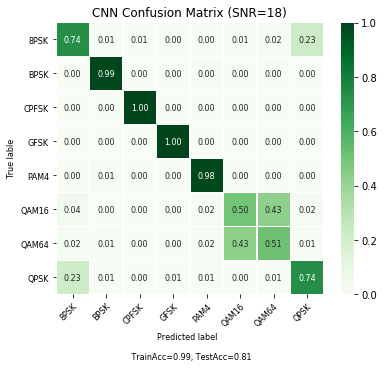

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"CNN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()

In [14]:
dic = "/content/drive/My Drive/Colab Notebooks/"
fig.savefig(dic+f"CNN2-CrossVal-132-132-ba{batch}-ep{epoch}(SNR={snr}).png", dpi=175, bbox_inches='tight')
print("Plot Saved!")

Plot Saved!
